# Data Preprocessing  

## 0. Import libraries

In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.interpolate import interp1d

## 1. Load dataset

In [14]:
df1c = pd.read_csv('/home/sbml/battery_rgb/paper_data/raw_data/lfp/25C/SNL_18650_LFP_25C_0-100_0.5-1C_a_cycle_data.csv')
df1t = pd.read_csv('/home/sbml/battery_rgb/paper_data/raw_data/lfp/25C/SNL_18650_LFP_25C_0-100_0.5-1C_a_timeseries.csv')
df2c = pd.read_csv('/home/sbml/battery_rgb/paper_data/raw_data/nca/25C/SNL_18650_NCA_25C_0-100_0.5-1C_a_cycle_data.csv')
df2t = pd.read_csv('/home/sbml/battery_rgb/paper_data/raw_data/nca/25C/SNL_18650_NCA_25C_0-100_0.5-1C_a_timeseries.csv')
df3c = pd.read_csv('/home/sbml/battery_rgb/paper_data/raw_data/nmc/25C/SNL_18650_NMC_25C_0-100_0.5-1C_a_cycle_data.csv')
df3t = pd.read_csv('/home/sbml/battery_rgb/paper_data/raw_data/nmc/25C/SNL_18650_NMC_25C_0-100_0.5-1C_a_timeseries.csv')

df_tlist = [df1t, df2t, df3t]
df_clist = [df1c, df2c, df3c]

df_titles = ['LFP_25C_0.5-1C_a', 'NCA_25C_0.5-1C_a', 'NMC_25C_0.5-1C_a']

'''
df_titles = ['LFP_25C_0.5-1C_a', 'LFP_25C_0.5-1C_b', 'LFP_25C_0.5-1C_c', 'LFP_25C_0.5-1C_d',
             'NCA_25C_0.5-1C_a', 'NCA_25C_0.5-1C_b', 'NCA_25C_0.5-1C_c', 'NCA_25C_0.5-1C_d',
             'NMC_25C_0.5-1C_a', 'NMC_25C_0.5-1C_b', 'NMC_25C_0.5-1C_c', 'NMC_25C_0.5-1C_d']
'''

"\ndf_titles = ['LFP_25C_0.5-1C_a', 'LFP_25C_0.5-1C_b', 'LFP_25C_0.5-1C_c', 'LFP_25C_0.5-1C_d',\n             'NCA_25C_0.5-1C_a', 'NCA_25C_0.5-1C_b', 'NCA_25C_0.5-1C_c', 'NCA_25C_0.5-1C_d',\n             'NMC_25C_0.5-1C_a', 'NMC_25C_0.5-1C_b', 'NMC_25C_0.5-1C_c', 'NMC_25C_0.5-1C_d']\n"

In [15]:
for i in df_clist:
    print(max(i['Cycle_Index']))

3545.0
654.0
521.0


## 2. Make Dataframe 

In [16]:
scaler = MinMaxScaler()

rgb_list = [] 
Test_time_list = []
title_list = []
cap_list = []
cycle_list = []
soh_list = []
rgb_length_padd = []
scaled_rgb = []
for cnt in range(0, len(df_tlist)):

    df = df_tlist[cnt]
    df_cap = df_clist[cnt]

    cycle_index = df['Cycle_Index'].tolist()
    cycle_index = list(set(cycle_index))
    cap_cycle = df_cap['Discharge_Capacity (Ah)'].tolist()
    cap_initial = cap_cycle[0]
    
    for i in range(1,len(cycle_index)+1):
        cap = cap_cycle[i-1]
        df2 = df[df['Cycle_Index'] == i]
        r = df2['Voltage (V)'].tolist()
        g = df2['Current (A)'].tolist()
        b = df2['Cell_Temperature (C)'].tolist()
        x = df2['Test_Time (s)'].tolist()
        rgb = [(r[i], g[i], b[i]) for i in range(len(x))] 
        soh = cap/cap_initial
        
        if r == [] or g == [] or b == [] :
            r2b2g2 = rgb
        else:

            r2 = scaler.fit_transform(np.array(r).reshape(-1,1)).reshape(1,-1).tolist()[0]
            g2 = scaler.fit_transform(np.array(g).reshape(-1,1)).reshape(1,-1).tolist()[0]
            b2 = scaler.fit_transform(np.array(b).reshape(-1,1)).reshape(1,-1).tolist()[0]
            r2b2g2 = [(int(r2[cnt]*255), int(g2[cnt]*255), int(b2[cnt]*255)) for cnt in range(len(r2))]


        
        rgb_length_padd.append(len(rgb))
        soh_list.append(soh)
        cycle_list.append(i)
        cap_list.append(cap)
        rgb_list.append((rgb))
        title_list.append(df_titles[cnt])
        scaled_rgb.append(r2b2g2)

In [21]:
columns = ['Dataset', '#cycle', 'Capacity(max_discharge)', 'RGB']
df = pd.DataFrame({'Dataset':title_list, '#cycle' : cycle_list, 'Capacity(dis)' : cap_list, 'SOH' : soh_list, 'RGB' : rgb_list, 'scaled_RGB' : scaled_rgb, 'RGB_length' : rgb_length_padd} )
df

,Dataset,#cycle,Capacity(dis),SOH,RGB,scaled_RGB,RGB_length
0,LFP_25C_0.5-1C_a,1,1.032,1.000000,"[(2.867, 0.0, 25.417), (2.867, 0.0, 25.417), (...","[(138, 127, 165), (138, 127, 165), (138, 127, ...",1438
1,LFP_25C_0.5-1C_a,2,1.034,1.001938,"[(2.715, 0.549, 25.234), (2.725, 0.549, 25.31)...","[(114, 254, 139), (115, 254, 157), (117, 254, ...",1451
2,LFP_25C_0.5-1C_a,3,1.035,1.002907,"[(2.723, 0.549, 25.158), (2.733, 0.549, 25.234...","[(115, 254, 106), (117, 254, 121), (118, 254, ...",1452
3,LFP_25C_0.5-1C_a,4,2.064,2.000000,"[(2.7, 0.0, 25.142), (2.7, 0.0, 25.142), (2.99...","[(112, 170, 59), (112, 170, 59), (158, 255, 61...",185
4,LFP_25C_0.5-1C_a,5,1.032,1.000000,"[(2.956, 0.549, 26.425), (3.089, 0.549, 25.998...","[(152, 255, 237), (174, 255, 170), (187, 255, ...",91
...,...,...,...,...,...,...,...
4712,NMC_25C_0.5-1C_a,516,2.357,0.794405,"[(3.27, 1.499, 29.415), (3.444, 1.499, 28.416)...","[(147, 255, 217), (167, 255, 167), (178, 255, ...",80
4713,NMC_25C_0.5-1C_a,517,2.365,0.797101,"[(3.27, 1.499, 29.429), (3.445, 1.499, 28.505)...","[(147, 255, 224), (167, 255, 177), (178, 255, ...",80
4714,NMC_25C_0.5-1C_a,518,2.365,0.797101,"[(1.994, 0.0, 30.034), (1.994, 0.0, 30.034), (...","[(0, 127, 238), (0, 127, 238), (27, 255, 236),...",1257
4715,NMC_25C_0.5-1C_a,519,2.365,0.797101,"[(2.858, 1.499, 25.838), (2.872, 1.499, 25.838...","[(99, 255, 94), (101, 255, 94), (102, 255, 94)...",1216


## 3. Remove outliers

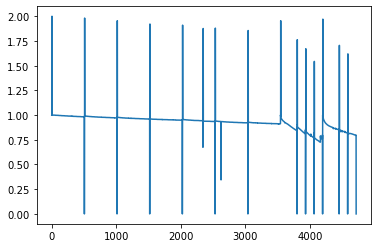

In [22]:
plt.plot(df['SOH'])

(0.75, 1.9311531007751939)

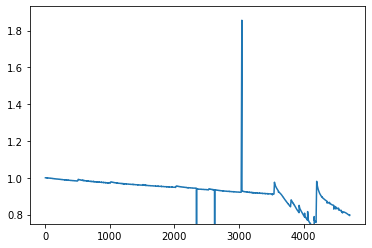

In [26]:
df2 = df[df['RGB_length'] < 125]
df2 = df2[df2['RGB_length'] > 70]
df2['SOH'].plot()
plt.ylim(0.75,)

<AxesSubplot:>

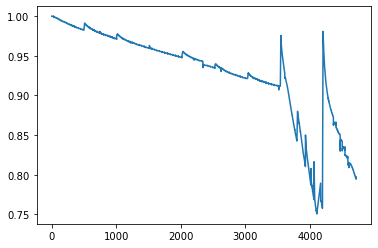

In [28]:
df2 = df2[df2['SOH'] <1.25]
df2 = df2[df2['SOH'] > 0.75]
df2['SOH'].plot()

In [29]:
rgb_list = df2['RGB'].tolist()
scaled_rgb_list = df2['scaled_RGB'].tolist()

# 4. Resize to unify the dimension

In [40]:
rgb_list_resized = []
for i in rgb_list :
    resized = cv.resize(np.array(i), dsize = (3,128), interpolation  = cv.INTER_AREA)
    rgb_list_resized.append(resized.tolist())

In [31]:
rgb_list_resized_scaled = []
for i in rgb_list_resized :     
    r = np.array(i)[:,0].tolist()
    g = np.array(i)[:,1].tolist()
    b = np.array(i)[:,2].tolist()
    
    r2 = scaler.fit_transform(np.array(r).reshape(-1,1)).reshape(1,-1).tolist()[0]
    g2 = scaler.fit_transform(np.array(g).reshape(-1,1)).reshape(1,-1).tolist()[0]
    b2 = scaler.fit_transform(np.array(b).reshape(-1,1)).reshape(1,-1).tolist()[0]
    r2b2g2 = [(int(r2[cnt]*255), int(g2[cnt]*255), int(b2[cnt]*255)) for cnt in range(len(r2))]
    rgb_list_resized_scaled.append(r2b2g2)

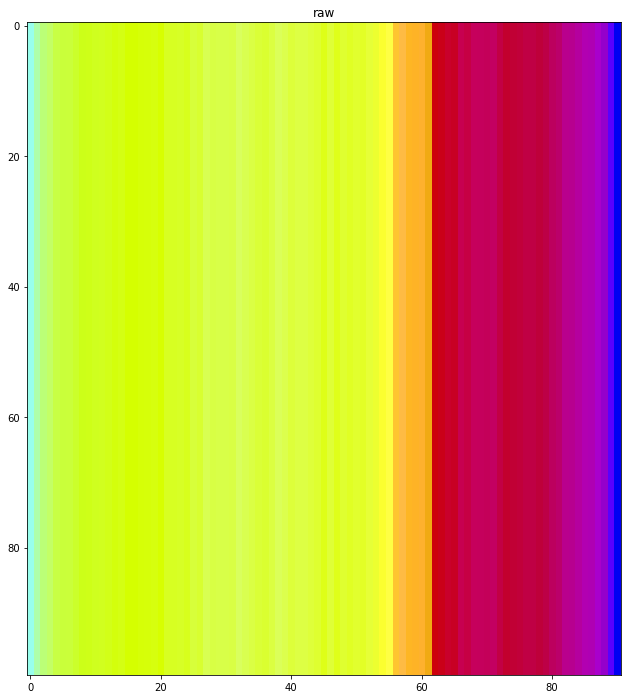

Text(0.5, 1.0, 'resized')

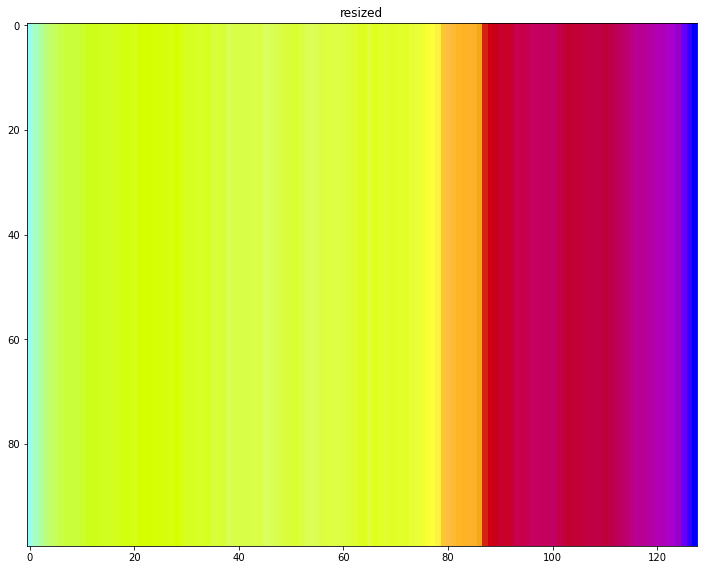

In [32]:
plt.figure(figsize=(12,12))
plt.imshow([scaled_rgb_list[0] for i in range(100)])
plt.title('raw')
plt.show()
plt.figure(figsize=(12,12))
plt.imshow([rgb_list_resized_scaled[0] for i in range(100)])
plt.title('resized')

In [33]:
df2['resized'] = rgb_list_resized
df2['resized_scaled'] = rgb_list_resized_scaled

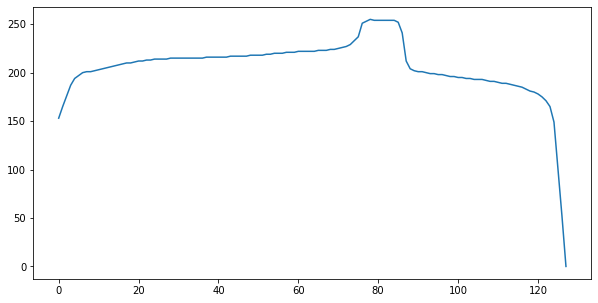

In [36]:
plt.figure(figsize = (10,5))
plt.plot(np.array(rgb_list_resized_scaled[0])[:,0])

In [41]:
df2.head()

,Dataset,#cycle,Capacity(dis),SOH,RGB,scaled_RGB,RGB_length,resized,resized_scaled
4,LFP_25C_0.5-1C_a,5,1.032,1.0,"[(2.956, 0.549, 26.425), (3.089, 0.549, 25.998...","[(152, 255, 237), (174, 255, 170), (187, 255, ...",91,"[[2.956, 0.549, 26.425], [3.0349230801463127, ...","[(153, 254, 242), (165, 254, 201), (176, 254, ..."
5,LFP_25C_0.5-1C_a,6,1.032,1.0,"[(2.957, 0.549, 26.319), (3.09, 0.549, 25.983)...","[(153, 255, 227), (174, 255, 172), (187, 255, ...",91,"[[2.957, 0.549, 26.319], [3.0359230801463126, ...","[(153, 254, 229), (165, 254, 196), (176, 254, ..."
6,LFP_25C_0.5-1C_a,7,1.032,1.0,"[(2.957, 0.549, 26.334), (3.09, 0.549, 25.937)...","[(152, 255, 216), (173, 255, 153), (186, 255, ...",91,"[[2.957, 0.549, 26.334], [3.0359230801463126, ...","[(152, 254, 216), (165, 254, 178), (176, 254, ..."
7,LFP_25C_0.5-1C_a,8,1.032,1.0,"[(2.957, 0.549, 26.487), (3.09, 0.549, 25.952)...","[(152, 255, 239), (173, 255, 164), (186, 255, ...",91,"[[2.957, 0.549, 26.487], [3.0359230801463126, ...","[(152, 254, 239), (165, 254, 194), (176, 254, ..."
8,LFP_25C_0.5-1C_a,9,1.032,1.0,"[(2.957, 0.549, 26.242), (3.09, 0.549, 25.937)...","[(152, 255, 208), (173, 255, 160), (186, 255, ...",91,"[[2.957, 0.549, 26.242], [3.0359230801463126, ...","[(152, 254, 211), (165, 254, 182), (176, 254, ..."


In [14]:
#df2.to_csv('/home/sbml/battery_rgb/220610/resize_not_intepolate/example_for_github/T25_only_case_a.csv')